### Fitting model description
1. 1 Voigt function for elastic, FWHM_G = 16.89, FWHM_L = 9
2. 1 DHO convoluted by a Gaussian with FWHM of 22.22 for the CDF 
3. *2* Voigt functions for phonons, FWHM the same as the elastic
4. 1 quadratic function for background

In [1]:
import sys 
sys.path.append('codes')
from scipy.optimize import curve_fit
import MyFunctions as mf
import matplotlib.pyplot as plt
import rixs_tools as rt
from scipy.signal import convolve
import numpy as np
from rixs_experiment import RIXS_EXP 
System = rt.create_system()

In [2]:
exp = RIXS_EXP()

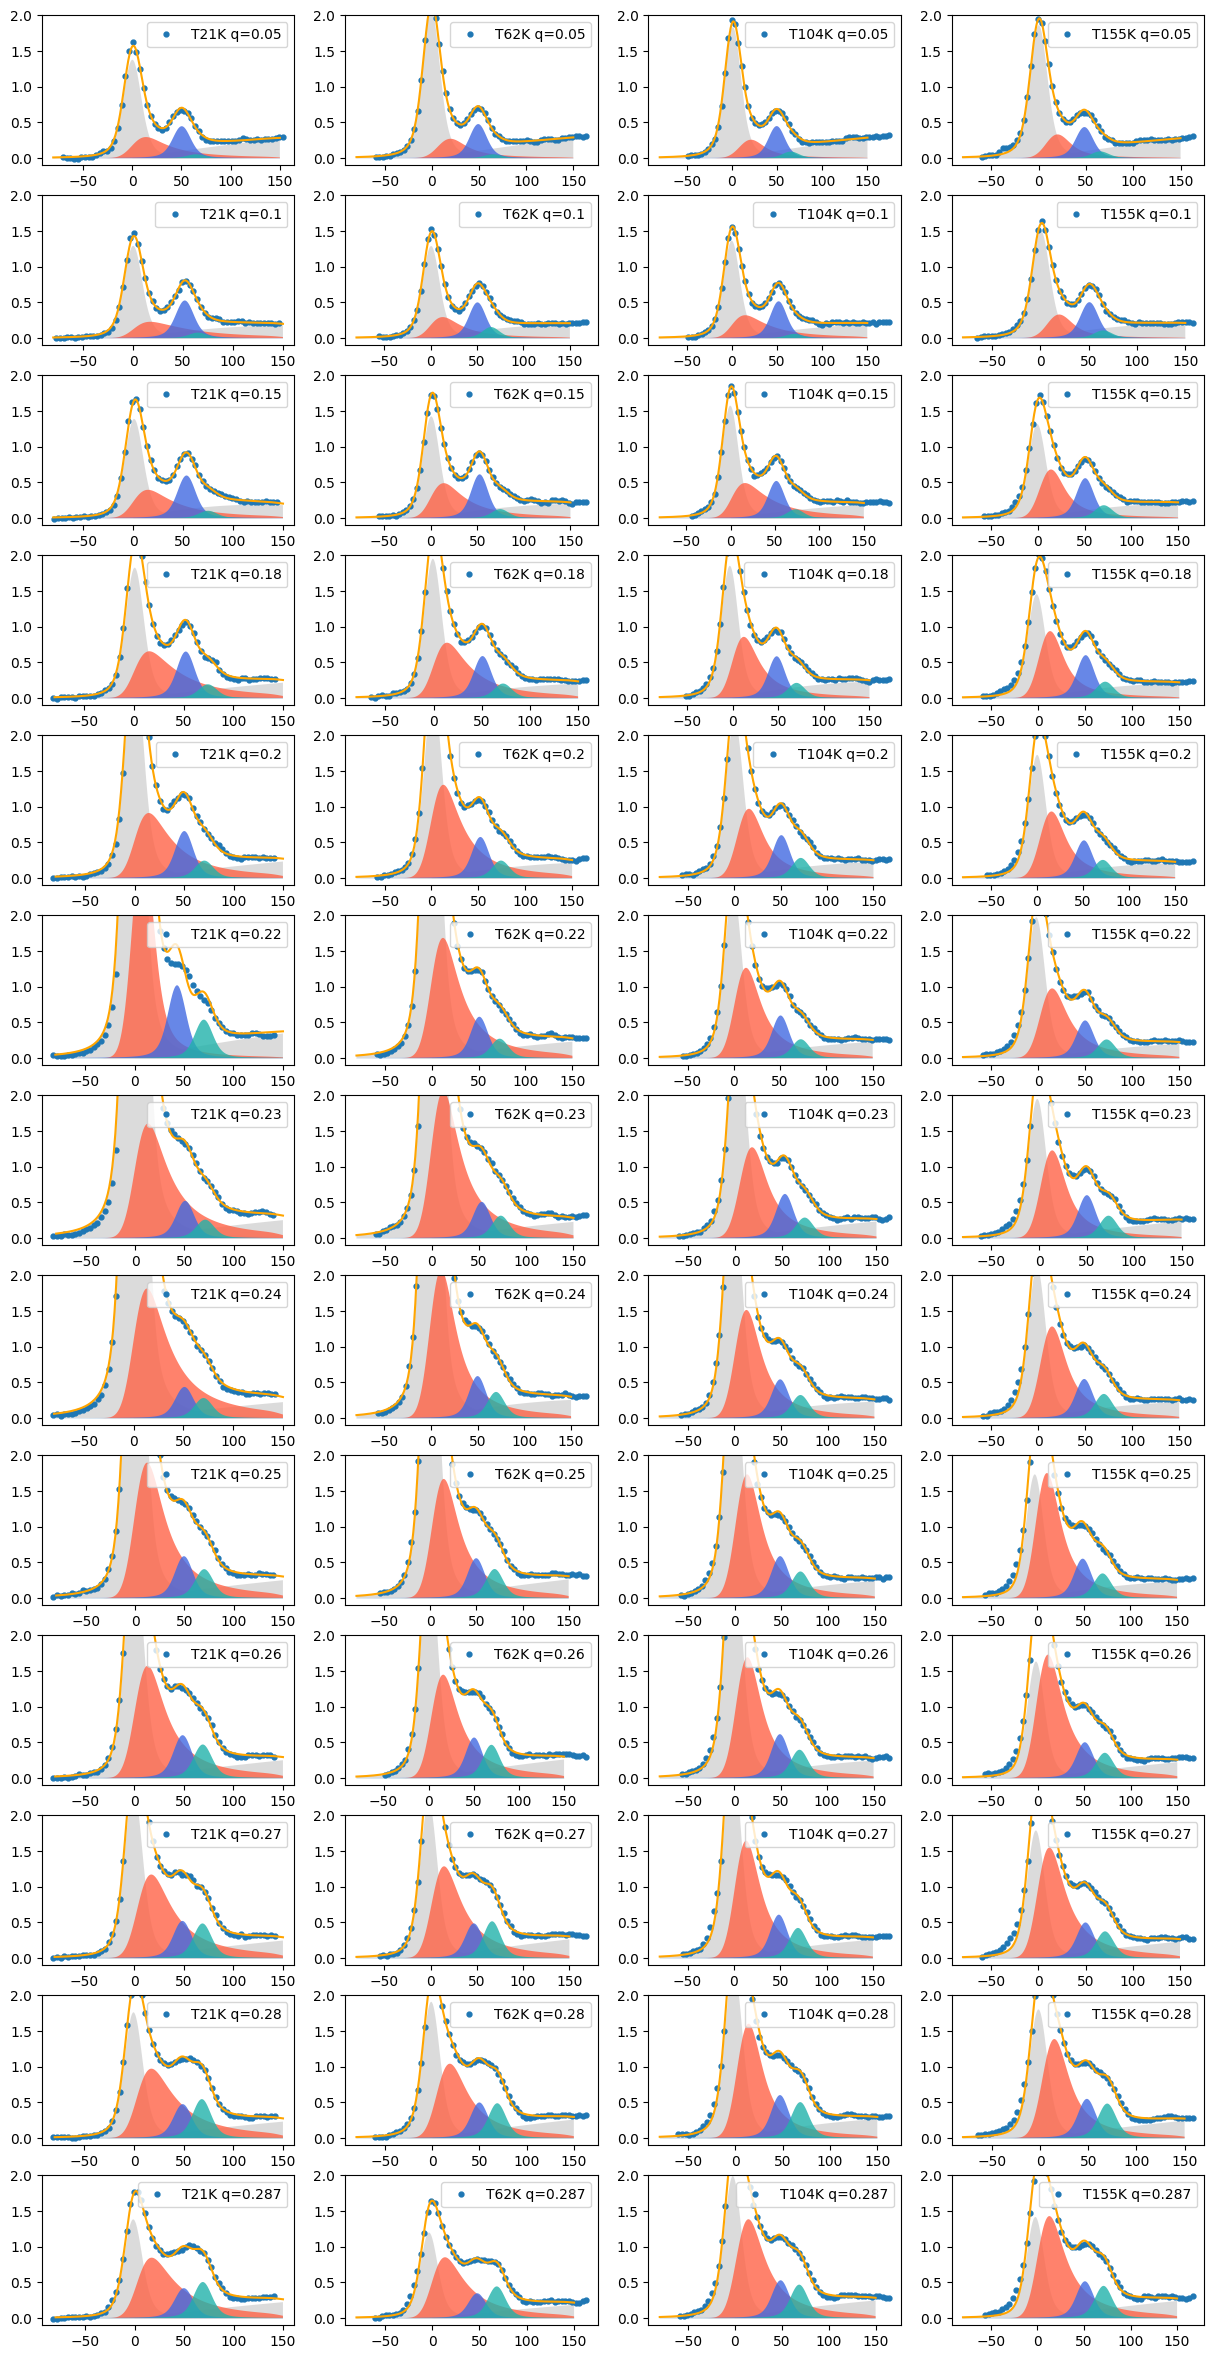

In [4]:
# basic fitting
fL = exp._fL_preset
fG = exp._fG_preset
global T

def fun_DHO_bose(x,x0,A,res):
    return mf.fun_DHO_original(x,x0,A,res) * 1/(1+np.exp(-x/T))

def function_to_fit(x, *parameters):
    res = exp._resolution
    global T
    y1 = mf.fun_voigt(x, *parameters[0:4])  # elastic
    # y2 = fun_DHO_bose(x,*parameters[4:7]) # CDF
    # y2 = mf.fun_DHO(x,*parameters[4:7]) # CDF
    y2 = mf.convoluted_fun(x, res, mf.fun_DHO, *parameters[4:7]) # CDF
    # y2 = mf.fun_lorentzian(x, *parameters[4:7]) # CDF
    # y2 = mf.fun_gaussian(x, *parameters[4:7]) # CDF
    y3 = mf.fun_voigt(x, *parameters[7:9], *parameters[2:4]) # 1st phonon 
    y4 = mf.fun_voigt(x, *parameters[9:11], *parameters[2:4]) # 2nd phonon
    y5 = mf.fun_voigt(x, *parameters[11:13], *parameters[2:4]) # 3rd phonon
    y6 = mf.fun_quadratic(x, *parameters[13:15])# background
    return y1+y2+y3+y4+y5+y6 

temperature_chars = exp._temperature_list_string
res = exp._resolution
fig, axs = plt.subplots(13,4,figsize=(15,30))
for i,temperature_char in enumerate(temperature_chars):
    T = exp._temperature_list_meV[i]

    popt =      [0, 5, fG, fL,\
                20, 1, 20,\
                40, 0.5,\
                52, 0,\
                75, 0.1,\
                160, 0.2]
    for j,q_index in enumerate(range(exp._q_size)):
        ax = axs[j,i]

        # test the function
        x = np.linspace(-80,150,1000)

        f_epsilon = 0.1
        epsilon = 0.001
        parameters_guess = popt


        parameters_lower = [-10, 0, fG-f_epsilon, fL-f_epsilon,\
                            0, 0, 0, \
                            30, 0,\
                            40, 0,\
                            65, 0,\
                            100, 0]
        parameters_upper = [10, 10, fG+f_epsilon, fL+f_epsilon,\
                            40, 10, 100,\
                            70, 10,\
                            70, 0+epsilon,\
                            105, 10,\
                            500, 10]
        data_T = exp.Aligned_interesting_data[temperature_char]
        energy = data_T[:,2*q_index]
        intensity = data_T[:,2*q_index+1]
        sigma = np.ones(len(energy))
        sigma[(energy>-15)&(energy<30)] = 0.7
        popt, perr = exp.basic_fit(temperature_char, q_index, function_to_fit, parameters_guess, parameters_bound=(parameters_lower, parameters_upper),sigma = sigma)        
        exp.Fit_results[temperature_char]['optimized_parameters'][q_index] = popt
        exp.Fit_results[temperature_char]['errors'][q_index] = perr
        exp.Fit_results[temperature_char]['fitting_info'] = "voigt for background, lorentzian for CDF, voigt for 3 phonons, quadratic for background"
        exp.plot_data(temperature_char, q_index, ax = ax)
        exp.plot_fit_conponent(function_to_fit, popt, ax = ax, fill = False, label = 'fit', color = 'orange') # total fit
        exp.plot_fit_conponent(mf.fun_voigt, popt[0:4], ax = ax, fill = True, label = 'elastic', color = 'lightgrey') # elastic
        exp.plot_fit_conponent(mf.fun_quadratic, popt[13:15], ax = ax, fill = True, label = 'background', color = 'lightgrey') # background
        # exp.plot_fit_conponent(mf.fun_DHO, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato') # CDF
        exp.plot_fit_conponent(mf.convoluted_fun, [res,mf.fun_DHO, *popt[4:7]], ax = ax, fill = True, label = 'CDF', color = 'tomato') # CDF
        # exp.plot_fit_conponent(mf.fun_lorentzian, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato')
        #exp.plot_fit_conponent(mf.fun_gaussian, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato')
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[7:9],*popt[2:4]], ax = ax, fill = True, label = '1st phonon', color = 'royalblue') # 1st phonon
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[9:11],*popt[2:4]], ax = ax, fill = True, label = '2nd phonon', color = 'lightgreen') # 2nd phonon
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[11:13],*popt[2:4]], ax = ax, fill = True, label = '3rd phonon', color = 'lightseagreen') # 3rd phonon
        ax.set_ylim(-0.1,2)
        # set legend to northeast
        
# save figure
#fig.tight_layout()
#fig.savefig('dho_fitting_results.jpg',dpi=100)




In [76]:
print(exp.Fit_results['T21K']['optimized_parameters'][8][4])
print(exp.Fit_results['T62K']['optimized_parameters'][8][4])
print(exp.Fit_results['T104K']['optimized_parameters'][8][4])
print(exp.Fit_results['T155K']['optimized_parameters'][8][4])

3.0305853228280015
8.474214365098135
7.624541468933552
0.20447224950142542


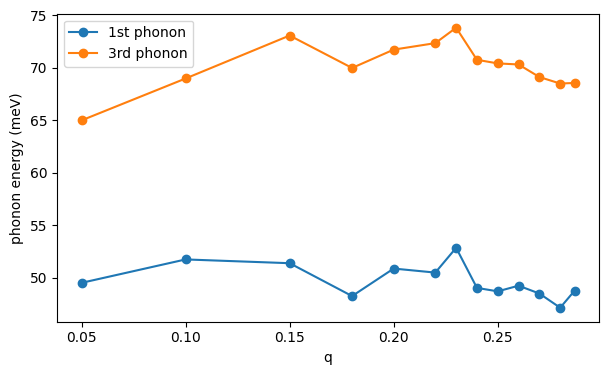

In [77]:
# plotting the first fitting parameter for each phonons as a function of q at 21K
fig, ax = plt.subplots(1,1,figsize=(7,4))
temperature_char = 'T104K'
phonon1_energy = np.zeros(exp._q_size)
phonon2_energy = np.zeros(exp._q_size)
phonon3_energy = np.zeros(exp._q_size)
for q_index in range(exp._q_size):
    phonon1_energy[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][7]
    phonon2_energy[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][9]
    phonon3_energy[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][11]

ax.plot(exp._q_list, phonon1_energy, '-o', label = '1st phonon')
# ax.plot(exp._q_list, phonon2_energy, '-o', label = '2nd phonon')
ax.plot(exp._q_list, phonon3_energy, '-o', label = '3rd phonon')
ax.set_xlabel('q')
ax.set_ylabel('phonon energy (meV)')
ax.legend()


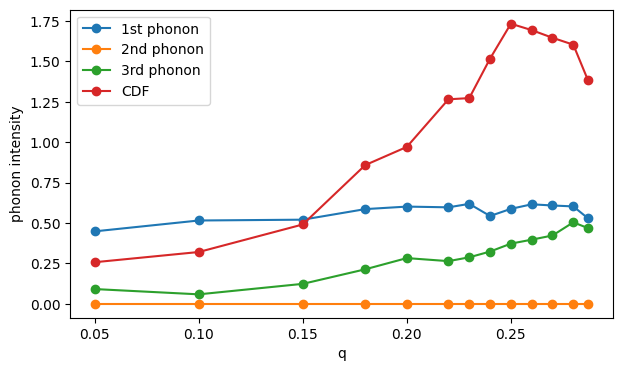

In [78]:
# plotting the second fitting parameter for each phonons as a function of q at T
fig, ax = plt.subplots(1,1,figsize=(7,4))
temperature_char = 'T104K'
phonon1_intensity = np.zeros(exp._q_size)
phonon2_intensity = np.zeros(exp._q_size)
phonon3_intensity = np.zeros(exp._q_size)
CDF_intensity = np.zeros(exp._q_size)
for q_index in range(exp._q_size):
    phonon1_intensity[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][8]
    phonon2_intensity[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][10]
    phonon3_intensity[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][12]
    CDF_intensity[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][5]

ax.plot(exp._q_list, phonon1_intensity, '-o', label = '1st phonon')
ax.plot(exp._q_list, phonon2_intensity, '-o', label = '2nd phonon')
ax.plot(exp._q_list, phonon3_intensity, '-o', label = '3rd phonon')
ax.plot(exp._q_list, CDF_intensity, '-o', label = 'CDF')
ax.set_xlabel('q')
ax.set_ylabel('phonon intensity')
ax.legend()


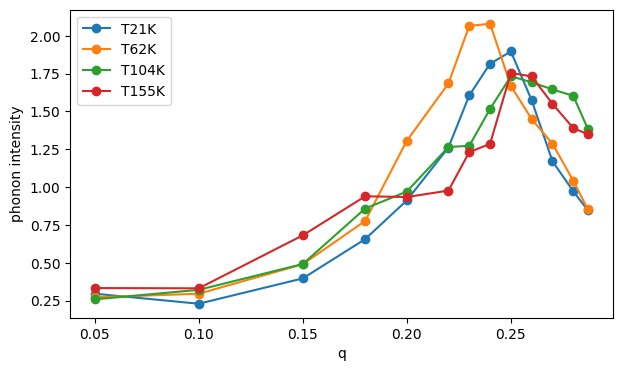

In [9]:
# plotting the second fitting parameter for each phonons as a function of q at T
fig, ax = plt.subplots(1,1,figsize=(7,4))
CDF_intensity = dict( T21K = np.zeros(exp._q_size), T62K = np.zeros(exp._q_size), T104K = np.zeros(exp._q_size), T155K = np.zeros(exp._q_size))
for temperature_char in exp._temperature_list_string:
    for q_index in range(exp._q_size):
        CDF_intensity[temperature_char][q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][5]
    ax.plot(exp._q_list, CDF_intensity[temperature_char], '-o', label = temperature_char)
ax.set_xlabel('q')
ax.set_ylabel('phonon intensity')
ax.legend()


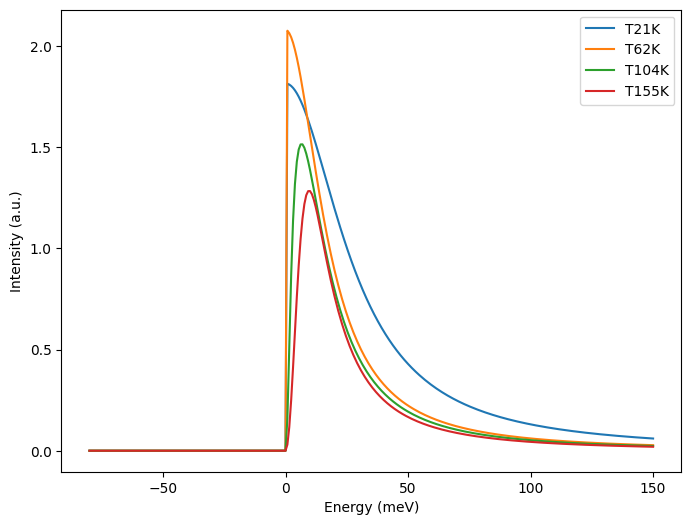

In [80]:
cdf_index = 7
# plot the CDF ay different temperatures
fig, ax = plt.subplots(1,1,figsize=(8,6))
for i,temperature_char in enumerate(temperature_chars):
    popt = exp.Fit_results[temperature_char]['optimized_parameters'][cdf_index]
    exp.plot_fit_conponent(mf.fun_DHO, popt[4:7], ax = ax, fill = False, label = temperature_char, color='C'+str(i))
    
ax.set_xlabel('Energy (meV)')
ax.set_ylabel('Intensity (a.u.)')
ax.legend()

### Remarks
1. The figure above is the DHO before convolution
2. The FWHM is not zero, which is a good news
3. 2-phonon fitting model seems to be a good choice 

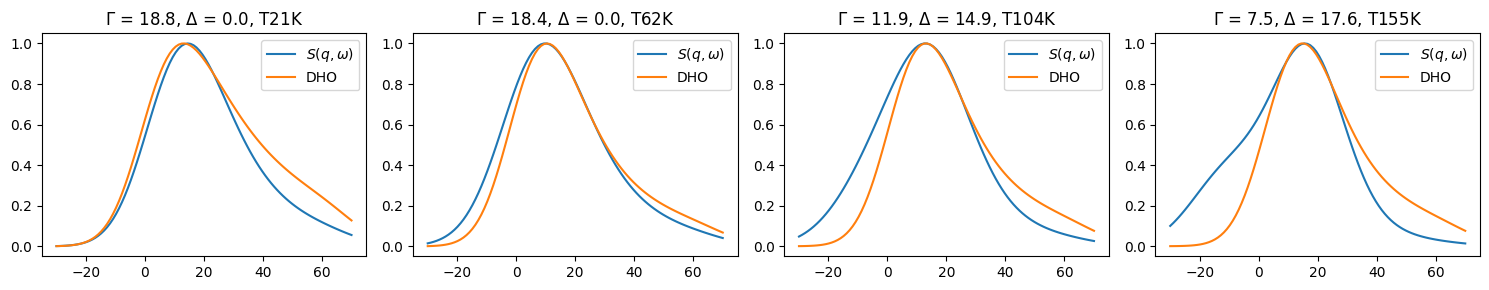

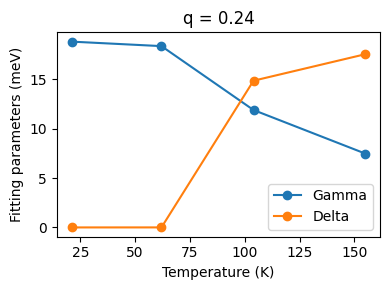

In [16]:
def fun_chi(x,A,Gamma,Delta):
        normalization_factor = 1/2 * 1/np.sqrt(Delta**2)
        chi = 1/(Delta**2 - (x + 1j*(Gamma))**2)
        return np.imag(chi * normalization_factor)*A

def fun_S(x,A,Gamma,Delta,T):
    return 2/(1-np.exp(-x/T))*fun_chi(x,A,Gamma,Delta)

def fun_S_convoluted(x,Gamma,Delta,T):
    x_left = min(x)
    x_right = max(x)
    x_left_shifted = x_left - (x_right + x_left)/2
    x_right_shifted = x_right - (x_right + x_left)/2
    x_gaussian = np.linspace(x_left_shifted,x_right_shifted,len(x))
    res = exp._resolution
    y = fun_S(x,1,Gamma,Delta,T)
    y_conv = convolve(y, mf.fun_gaussian(x_gaussian,0,1,res), mode='same')
    return y_conv/max(y_conv)
    
fig,axs = plt.subplots(1,4,figsize=(15,3))

# create empty list to store the fitting result
Gamma_list = np.zeros(len(exp._temperature_list_string))
Delta_list = np.zeros(len(exp._temperature_list_string))


for i,temperature_char in enumerate(exp._temperature_list_string):
    # fit CDF with fun_S_convoluted
    ax = axs[i]
    cdf_index = 7
    temperature = exp._temperature_list_meV[i]
    popt = exp.Fit_results[temperature_char]['optimized_parameters'][cdf_index]
    # fit the CDF with fun_S_convoluted
    x_data = np.linspace(-30,70,100)
    y_data = mf.convoluted_fun(x_data,res,mf.fun_DHO, *popt[4:7])
    y_data = y_data/max(y_data)
    p0 = [3,10,temperature]
    epsilon = 0.01
    bounds = ([0,0,temperature],[30,30,temperature+epsilon])
    sigma = np.ones(len(x_data))
    sigma[(x_data>10)&(x_data<26)] = 0.1
    popt, pcov = curve_fit(fun_S_convoluted, x_data, y_data, p0 = p0, bounds=bounds,sigma = sigma)
    Gamma_list[i] = popt[0]
    Delta_list[i] = popt[1]

    ax.plot(x_data, fun_S_convoluted(x_data,*popt), label = '$S(q,\omega)$')
    ax.plot(x_data, y_data, label = 'DHO')
    ax.legend()
    # display fitting result with only one digit
    popt = np.round(popt,1)
    ax.set_title(f"$\Gamma$ = {popt[0]}, $\Delta$ = {popt[1]}, "+ temperature_char)

fig.tight_layout()
fig.savefig('lsco_cdf_fitting_q024.jpg',dpi=100)

fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(exp._temperature_list_K, Gamma_list, '-o', label = 'Gamma')
ax.plot(exp._temperature_list_K, Delta_list, '-o', label = 'Delta')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Fitting parameters (meV)')
ax.set_title(f'q = {exp._q_list[cdf_index]}')
ax.legend()
fig.tight_layout()
fig.savefig('lsco_cdf_fitting_parameters_q024.jpg',dpi=100)

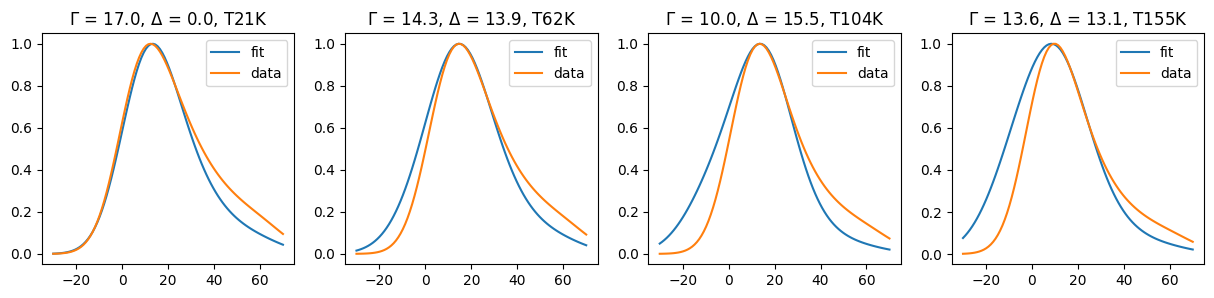

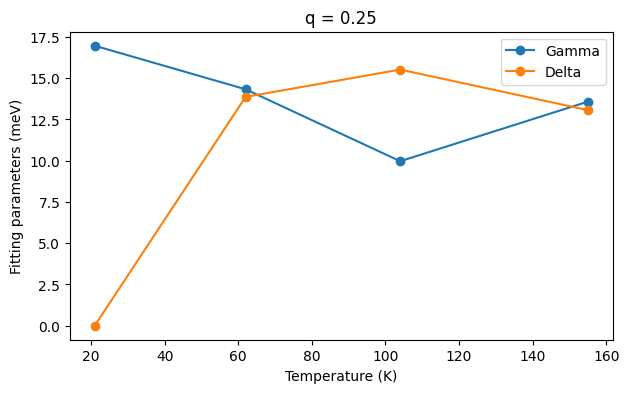

In [85]:
def fun_chi(x,A,Gamma,Delta):
        normalization_factor = 1/2 * 1/np.sqrt(Delta**2)
        chi = 1/(Delta**2 - (x + 1j*(Gamma))**2)
        return np.imag(chi * normalization_factor)*A

def fun_S(x,A,Gamma,Delta,T):
    return 2/(1-np.exp(-x/T))*fun_chi(x,A,Gamma,Delta)

def fun_S_convoluted(x,Gamma,Delta,T):
    x_left = min(x)
    x_right = max(x)
    x_left_shifted = x_left - (x_right + x_left)/2
    x_right_shifted = x_right - (x_right + x_left)/2
    x_gaussian = np.linspace(x_left_shifted,x_right_shifted,len(x))
    res = exp._resolution
    y = fun_S(x,1,Gamma,Delta,T)
    y_conv = convolve(y, mf.fun_gaussian(x_gaussian,0,1,res), mode='same')
    return y_conv/max(y_conv)
    
fig,axs = plt.subplots(1,4,figsize=(15,3))

# create empty list to store the fitting result
Gamma_list = np.zeros(len(exp._temperature_list_string))
Delta_list = np.zeros(len(exp._temperature_list_string))


for i,temperature_char in enumerate(exp._temperature_list_string):
    # fit CDF with fun_S_convoluted
    ax = axs[i]
    cdf_index = 8
    temperature = exp._temperature_list_meV[i]
    popt = exp.Fit_results[temperature_char]['optimized_parameters'][cdf_index]
    # fit the CDF with fun_S_convoluted
    x_data = np.linspace(-30,70,100)
    y_data = mf.convoluted_fun(x_data,res,mf.fun_DHO, *popt[4:7])
    y_data = y_data/max(y_data)
    p0 = [3,10,temperature]
    epsilon = 0.01
    bounds = ([0,0,temperature],[30,30,temperature+epsilon])
    sigma = np.ones(len(x_data))
    sigma[(x_data>10)&(x_data<26)] = 0.1
    popt, pcov = curve_fit(fun_S_convoluted, x_data, y_data, p0 = p0, bounds=bounds,sigma = sigma)
    Gamma_list[i] = popt[0]
    Delta_list[i] = popt[1]

    ax.plot(x_data, fun_S_convoluted(x_data,*popt), label = 'fit')
    ax.plot(x_data, y_data, label = 'data')
    ax.legend()
    # display fitting result with only one digit
    popt = np.round(popt,1)
    ax.set_title(f"$\Gamma$ = {popt[0]}, $\Delta$ = {popt[1]}, "+ temperature_char)

fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(exp._temperature_list_K, Gamma_list, '-o', label = 'Gamma')
ax.plot(exp._temperature_list_K, Delta_list, '-o', label = 'Delta')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Fitting parameters (meV)')
ax.set_title(f'q = {exp._q_list[cdf_index]}')
ax.legend()

43.03433810937213
gamma = 14.482051596093475, Delta = 13.814321792907263, T62K


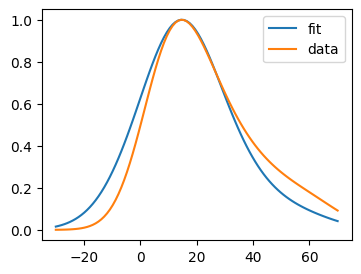

In [86]:
def fun_chi(x,A,Gamma,Delta):
        normalization_factor = 1/2 * 1/np.sqrt(Delta**2)
        chi = 1/(Delta**2 - (x + 1j*(Gamma))**2)
        return np.imag(chi * normalization_factor)*A

def fun_S(x,A,Gamma,Delta,T):
    return 2/(1-np.exp(-x/T))*fun_chi(x,A,Gamma,Delta)

def fun_S_convoluted(x,Gamma,Delta,T):
    x_left = min(x)
    x_right = max(x)
    x_left_shifted = x_left - (x_right + x_left)/2
    x_right_shifted = x_right - (x_right + x_left)/2
    x_gaussian = np.linspace(x_left_shifted,x_right_shifted,len(x))
    res = exp._resolution
    y = fun_S(x,1,Gamma,Delta,T)
    y_conv = convolve(y, mf.fun_gaussian(x_gaussian,0,1,res), mode='same')
    return y_conv/max(y_conv)
    

i = 1
# fit CDF with fun_S_convoluted
cdf_index = 8
fig, ax = plt.subplots(1,1,figsize=(4,3))
temperature_char = exp._temperature_list_string[i]
temperature = exp._temperature_list_meV[i]
popt = exp.Fit_results[temperature_char]['optimized_parameters'][cdf_index]
# fit the CDF with fun_S_convoluted
x_data = np.linspace(-30,70,100)
y_data = mf.convoluted_fun(x_data,res,mf.fun_DHO, *popt[4:7])
print(popt[6])
y_data = y_data/max(y_data)
p0 = [0.2,5,temperature]
epsilon = 0.01
bounds = ([0,0,temperature],[30,30,temperature+epsilon])
sigma = np.ones(len(x_data))
sigma[(x_data>10)&(x_data<25)] = 0.1
popt, pcov = curve_fit(fun_S_convoluted, x_data, y_data, p0 = p0, bounds=bounds,sigma = sigma)


ax.plot(x_data, fun_S_convoluted(x_data,*popt), label = 'fit')
ax.plot(x_data, y_data, label = 'data')
ax.legend()
print(f"gamma = {popt[0]}, Delta = {popt[1]}, "+ temperature_char)

# Problems
1. The FWHM of the CDF is too close to the resolution. Super hard to extract the FWHM before convolution because it's too close to zero. Hard to fit...